In [83]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed_3/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16
MAX_LEN = 200

# -------------------------------- load data ---------------------------------------
f = h5py.File(pred_file, 'r')
preds = np.array(f['main']).astype('float32')
g = h5py.File(gt_seg,'r')
gt_seg = g['main']
print preds.shape

(3, 432, 432, 432)


# Divide Volumes, set up args

In [84]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_vll/'
dims = np.array(preds.shape[1:])
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
# num_vols[0] = 2 # delete this!
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts,ends = [],[]
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas - [3,3,3] +3*np.array([x==0,y==0,z==0]))
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra +[3,3,3])
args = []
for i in range(len(starts)):
    s,e = starts[i],ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print i,s,e,pred_vol.shape
    args.append((pred_vol,out_folder+dim_to_name(s)))    

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]
0 [0 0 0] [148 148 148] (3, 148, 148, 148)
1 [  0   0 141] [148 148 292] (3, 148, 148, 151)
2 [  0   0 285] [148 148 439] (3, 148, 148, 147)
3 [  0 141   0] [148 292 148] (3, 148, 151, 148)
4 [  0 141 141] [148 292 292] (3, 148, 151, 151)
5 [  0 141 285] [148 292 439] (3, 148, 151, 147)
6 [  0 285   0] [148 439 148] (3, 148, 147, 148)
7 [  0 285 141] [148 439 292] (3, 148, 147, 151)
8 [  0 285 285] [148 439 439] (3, 148, 147, 147)
9 [141   0   0] [292 148 148] (3, 151, 148, 148)
10 [141   0 141] [292 148 292] (3, 151, 148, 151)
11 [141   0 285] [292 148 439] (3, 151, 148, 147)
12 [141 141   0] [292 292 148] (3, 151, 151, 148)
13 [141 141 141] [292 292 292] (3, 151, 151, 151)
14 [141 141 285] [292 292 439] (3, 151, 151, 147)
15 [141 285   0] [292 439 148] (3, 151, 147, 148)
16 [141 285 141] [292 439 292] (3, 151, 147, 151)
17 [141 285 285] [292 439 439] (3, 151, 147, 147)
18 [285   0   0] [439 148 148] (3, 147, 148, 148)
19 [285  

# Call Watershed

In [85]:
def zwshed_h5_par(arg):
    (pred_vol,seg_save_path) = arg
    zwatershed_basic_h5(pred_vol,seg_save_path)
    print "finished",seg_save_path,"watershed"
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)
# zwshed_h5_par(args[0])

finished /nobackup/turaga/singhc/par_zwshed_3/0_0_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_141_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_141_141_vll/ watershed
finished /nobackup

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Stitch

i,x,y,z 0 0 0 0
	merging numbers, 0 keys ... 
	before nsegs= 12798 num0= 6248902
	after nsegs= 12798 num0= 6248902
	renumbering all... 12798 num0= 6248902
i,x,y,z 1 0 0 1
len re_z 183
	merging numbers, 183 keys ... 
	before nsegs= 26638 num0= 3116661
	after nsegs= 26604 num0= 3116661
	renumbering all... 26604 num0= 

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


3116661

STARTING Y

	merging numbers, 0 keys ... 
	before nsegs= 26604 num0= 21274485
	after nsegs= 26604 num0= 21274485


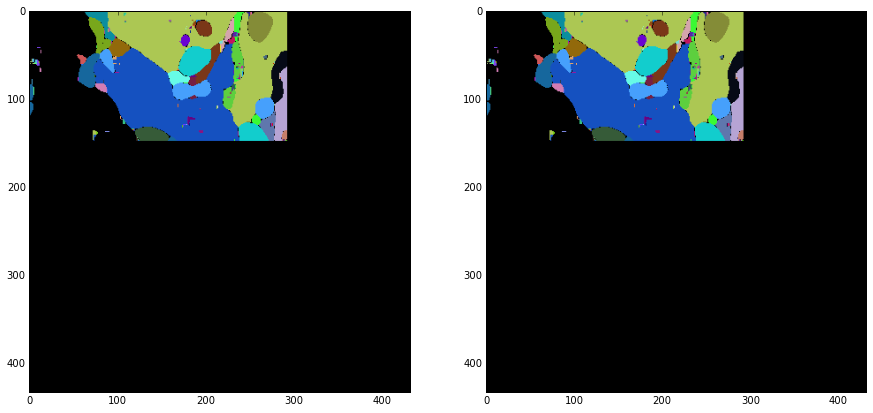

	renumbering all... 26604 num0= 21274485
i,x,y,z 3 0 1 0
	merging numbers, 0 keys ... 
	before nsegs= 23464 num0= 6378353
	after nsegs= 23464 num0= 6378353
	renumbering all... 23464 num0= 6378353
i,x,y,z 4 0 1 1
len re_z 369
	merging numbers, 369 keys ... 
	before nsegs= 43820 num0= 3182027
	after nsegs= 43773 num0= 3182027
	renumbering all... 43773 num0= 3182027

STARTING Y

	merging numbers, 856 keys ... 
	before nsegs= 68593 num0= 15102238
	after nsegs= 68016 num0= 15102238


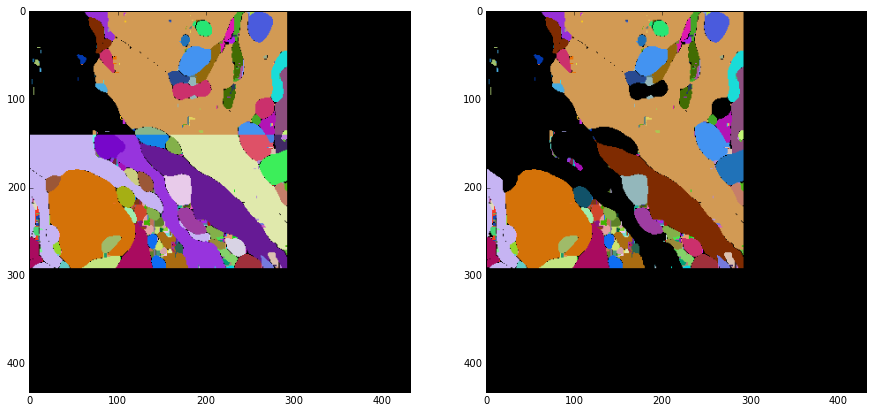

	renumbering all... 68016 num0= 15102238
i,x,y,z 9 1 0 0
	merging numbers, 0 keys ... 
	before nsegs= 23254 num0= 6373630
	after nsegs= 23254 num0= 6373630
	renumbering all... 23254 num0= 6373630
i,x,y,z 10 1 0 1
len re_z 590
	merging numbers, 590 keys ... 
	before nsegs= 50537 num0= 3178394
	after nsegs= 50449 num0= 3178394
	renumbering all... 50449 num0= 3178394

STARTING Y

	merging numbers, 0 keys ... 
	before nsegs= 50449 num0= 21704282
	after nsegs= 50449 num0= 21704282


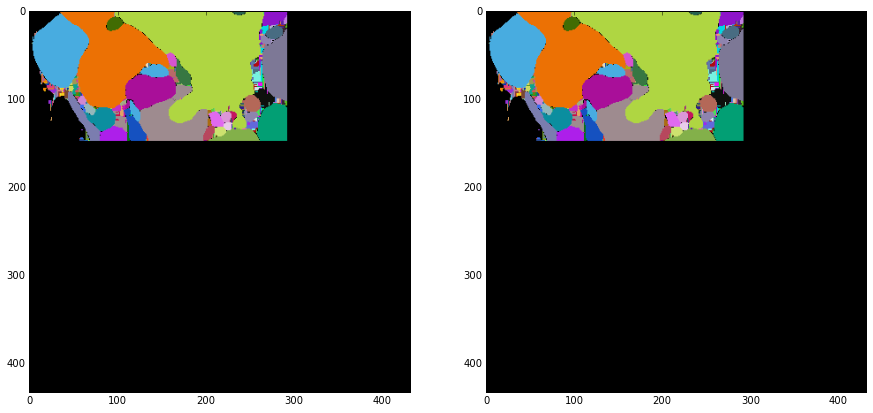

	renumbering all... 50449 num0= 21704282
i,x,y,z 12 1 1 0
	merging numbers, 0 keys ... 
	before nsegs= 20330 num0= 6500568
	after nsegs= 20330 num0= 6500568
	renumbering all... 20330 num0= 6500568
i,x,y,z 13 1 1 1
len re_z 394
	merging numbers, 394 keys ... 
	before nsegs= 42305 num0= 3247338
	after nsegs= 42244 num0= 3247338
	renumbering all... 42244 num0= 3247338

STARTING Y

	merging numbers, 841 keys ... 
	before nsegs= 90511 num0= 15407761
	after nsegs= 89970 num0= 15407761


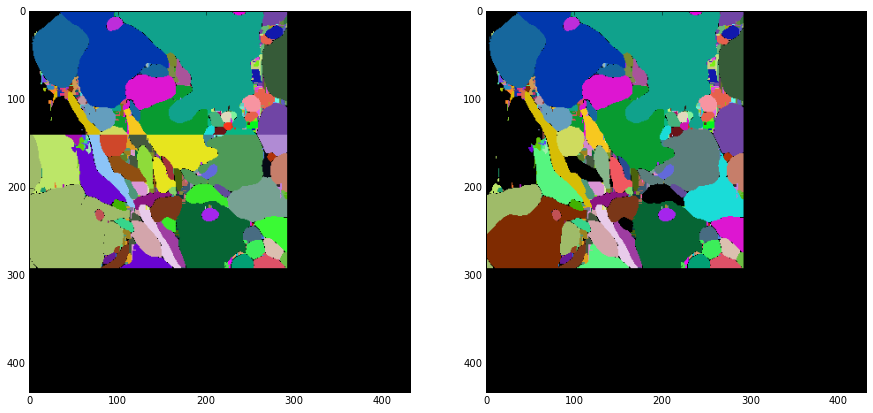

	renumbering all... 89970 num0= 15407761


'\n    ybar[ybar!=0] += np.max(seg_out)+1\n    # end ybar -------------------------------------------------------\n    if x==0: # don\'t merge\n        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]\n    else: # merge\n        re_x = calc_renums(edge_mins=seg_out[sx[0],:,:],edge_maxes=ybar[0,:,:],re=re_x)\n        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]\nseg_out = merge_and_renum(re_x,seg_out,inc=False,p=False)\n\nprint "finished"\n# display_seg_xy(seg_out)\n'

In [89]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
COUNT_THRESH = 0
filename = 'basic.h5'
i = 0
seg_out = np.zeros(dims,dtype='uint64')
re_x = {}
for x in range(1): #num_vols[0]):
    i = x*num_vols[1]*num_vols[2]
    sx,ex = starts[i],ends[i]
    
    # start ybar --------------------------------------------------
    xdim = deltas[0]+7
    if x==0:
        xdim = deltas[0]+4
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')
    counts_y = {}
    for y in range(0,2): #num_vols[1]):
        i = x*num_vols[1]*num_vols[2]+y*num_vols[2]
        sy,ey = starts[i], ends[i]
        
        # start zbar -----------------------------------------------
        ydim = deltas[1]+7
        if y==0:
            ydim = deltas[1]+4
        if y==num_vols[1]-1:
            ydim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        
        counts_z = {}
        for z in range(0,2): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            seg = np.array(h5py.File(arg[1]+filename,'r')['seg'])
            seg[seg!=0]+=np.max(zbar)+1
            re_z = {} # maxes -> mins
            
            print "i,x,y,z",i,x,y,z
            if z==0: 
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            else:         
                re_z = calc_renums(edge_mins=zbar[:,:,s[2]+3],edge_maxes=seg[:,:,3], re=re_z, counts=counts_z)
                print "len re_z",len(re_z)
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            zbar = merge_and_renum(re_z,zbar,inc=False,p=False,counts=counts_z)
        zbar[zbar!=0] += np.max(ybar)+1
        # end zbar --------------------------------------------------    
        print "\nSTARTING Y\n"
        re_y = {}
        
        if y==0: # don't merge
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]
        else: # merge
            re_y = calc_renums(edge_mins=ybar[0:,s[1]+3,:],edge_maxes=zbar[0:,3,:], re=re_y, counts=counts_y)
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]

        ybar = merge_and_renum(re_y,ybar,inc=False,p=True,counts=counts_y)
'''
    ybar[ybar!=0] += np.max(seg_out)+1
    # end ybar -------------------------------------------------------
    if x==0: # don't merge
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
    else: # merge
        re_x = calc_renums(edge_mins=seg_out[sx[0]+3,:,:],edge_maxes=ybar[3,:,:],re=re_x)
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
seg_out = merge_and_renum(re_x,seg_out,inc=False,p=False)

print "finished"
# display_seg_xy(seg_out)
'''

In [81]:
# stitch methods
def calc_renums(edge_mins,edge_maxes, re, counts={}):
    edge_mins = edge_mins.ravel()
    edge_maxes = edge_maxes.ravel()
#     print "edge_mins",edge_mins
#     print "edge_maxes",edge_maxes
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min==0 and not edge_max==0:
            if not edge_max==edge_min:
                if edge_max in re: # already in map
                    old_min = re[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        re[merge_max] = merge_min
                        add_or_inc(merge_max,merge_min,counts)
            re[edge_max] = edge_min
            add_or_inc(edge_max,edge_min,counts)
    return re
    
def prune_and_renum(seg,sizeThreshold=1):
    # renumber the components in descending order by size
    segId,segSizes = np.unique(seg, return_counts=True)
    descOrder = np.argsort(segSizes)[::-1]
    renum = np.zeros(segId.max()+1,dtype=np.uint64)
#     segId = segId[descOrder]
    segSizes = segSizes[descOrder]
    print "\tsizes 1...",segSizes[0:10]
    renum[segId] = np.arange(1,len(segId)+1)

    renum[segId] = np.arange(1,len(segId)+1)
    renum[0]=0
    seg = renum[seg]
    segId,segSizes = np.unique(seg, return_counts=True)
    descOrder = np.argsort(segSizes)[::-1]
    segSizes = segSizes[descOrder]
    print "\tsizes 2...",segSizes[0:10]
    return seg

def add_or_inc(key_max,key_min,d):
    key = (key_max,key_min)
    if not key in d:
        d[key] = 1
    else:
        d[key] +=1
    
def merge_and_renum(renums,zbar,inc=True,p=False,counts={}):
    # only keep strongest edges
    renums = {}
    count_maxes = {}
    for pair in counts:
        count = counts[pair]
        e1,e2 = pair
        if e1 in renums:
            if count > count_maxes[e1]:
                renums[e1] = e2
                count_maxes[e1] = count
        else:
            renums[e1] = e2
            count_maxes[e1] = count
            
            
    
    # merge numbers
#     print "renums",renums
#     print "counts",counts
#     print "len counts",len(counts)
    sum_counts = 0
    for key in counts:
        sum_counts += counts[key]
#     print "ave counts",float(sum_counts) / len(counts)
#     print "counts",counts
#     print "renums",renums
    renums2 = {}
    print "\tmerging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        if counts[(key,val)] > COUNT_THRESH:
            while val in renums:
                val = renums[val]
            renums2[key] = val
#     print "renums filtered",renums2
            
    print "\tbefore nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        fig = plt.figure(figsize=(15, 7))
        plt.subplot(1,2,1)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    
    mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
    mp[renums2.keys()] = renums2.values()
    zbar = mp[zbar]
    print "\tafter nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        plt.subplot(1,2,2)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    plt.show()
    
    # renumber all
#     zbar = prune_and_renum(zbar,2)
    print "\trenumbering all...",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
#     if p:
#         plt.imshow(zbar[0, :, :], cmap=cmap)
#     plt.show()
#     print "\tend all...",np.max(zbar),"num0=",np.sum(zbar==0)
    if inc:
        zbar[zbar!=0] += np.max(zbar)+1
    return zbar

# Visualize

In [138]:
def display_affs(raw):
    plt.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def display_seg_xy(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[:, :, depth], cmap=cmap)
    plt.show()

(3, 125, 300, 300)
preds0
0.999997
0.000641769
0.734931
1.0
0.058145
0.860175
1.0
0.124801
0.86506
(125, 300, 300, 3)
(125, 313, 314)


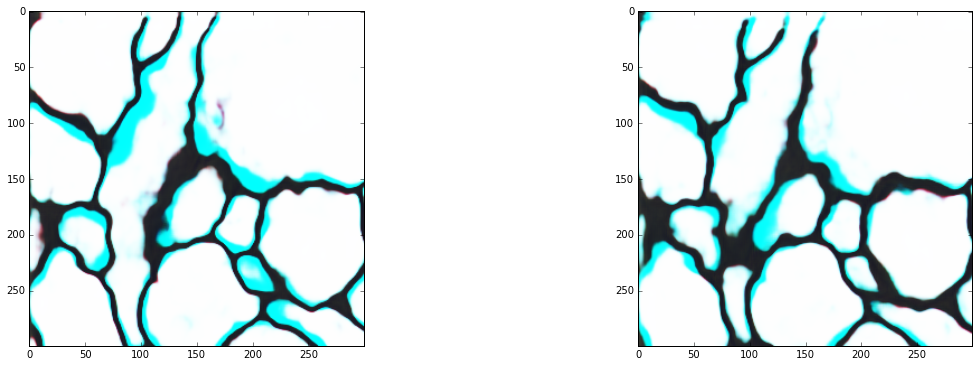

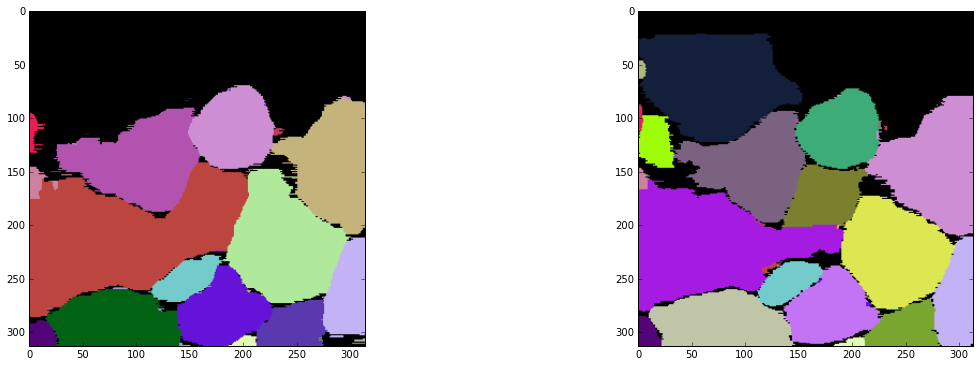

In [27]:
# display_affs(preds,preds,preds)
p_small = preds[:300,:300,:300,:300]
print p_small.shape
preds0 = p_small[0,:,:,:]
print "preds0"
print np.max(preds0)
print np.min(preds0)
print np.average(preds0)
preds1 = p_small[1,:,:,:]
print np.max(preds1)
print np.min(preds1)
print np.average(preds1)
preds2 = p_small[2,:,:,:]
print np.max(preds2)
print np.min(preds2)
print np.average(preds2)
raw = np.transpose(p_small,(1,2,3,0))
print raw.shape
# seg = zwatershed(p_small,[2000])[0]
print seg.shape
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(raw[50, :, :, :])
plt.subplot(1,2,2)
plt.imshow(raw[51, :, :, :])
plt.show()
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(seg[50, :, :],cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(seg[51, :, :],cmap=cmap)
plt.show()